# Analysis for RNA-DNA p-brain tissue sample

Original script template based on: 

2021-04-23 smRNA and 04-26 CTP-09 MOP marker gene DNA-MERFISH

by Pu Zheng

2020.04.30



Note from Shiwei:

Example for running the [find chrom center function] added;

Updated script for 20210624-P_Forebrain_smFISH_CTP09 RNA-DNA experiment, where RNA is detected by smRNA (using adaptors/EC), and followed by 70% FA harsh wash + PFA post-fix, and DNA-FISH using CTP09.






# Brain region annotations and additional info below:

# modified by Pu Zheng

2021.08.12

In [21]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

178388


## set parameters

In [2]:
reload(ia)
reload(classes)
reload(get_img_info)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)

reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_5\20210624-P_Forebrain_smFISH_CTP09',
             'save_folder':r'\\10.245.74.40\Turing3\Pu\Analyzed_Data\20210624-P_Forebrain_smFISH_CTP09',
             #'save_folder':r'D:\Pu_Temp\202009_IgH_proB_DMSO_2color',
             'experiment_type': 'DNA',
             'num_threads': 20,
             #'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210514-Corrections_2color_50_new_fiber',
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor',
             'shared_parameters':{
                     'single_im_size':[60,2048,2048],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'corr_bleed':False,
                     'min_num_seeds':250,
                     'max_num_seeds': 2000,
                     'spot_seeding_th': 150,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                 }, 
             }

In [3]:
# process fov in batch
#fov_ids = np.concatenate([np.arange(2,8), np.arange(83,89), [63,64,66,67,68,70]])
#fov_ids = list(range(7,10))
fov_ids = [2]


for _fov_id in fov_ids:
    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=True,
                                              )

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 39
- Number of field of views: 90
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20210624-P_Forebrain_smFISH_CTP09\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
dict_keys(['H1R1', 'H2R2', 'H3R3', 'H7C1', 'H8C2', 'H27C21', 'H28C22', 'H29C23', 'H30C24', 'H31C25', 'H32C26', 'H33C27', 'H34C28', 'H35C29', 'H36C30', 'H17C11', 'H18C12', 'H19C13', 'H20C14', 'H21C15', 'H22C16', 'H23C17', 'H24C18', 'H25C19', 'H26C20', 'H9C3', 'H10C4', 'H11C5', 'H12C6', 'H13C7', 'H14C8', 'H15C9', 'H16C10', 'H37GNkx750', 'H38GSst750Cnd647', 'H39GS177S326'])
- 36 folders are found according to color-usage annotation.
+ loading fov_info from file: \\10.245.74.40\Turing3\Pu\Analyzed_Data\20210624-P_Forebrain_smFISH_CTP09\Conv_zscan_02.hdf5
try loading: cand_chrom_coords_alt
try loading: cand_chrom_coords_alt_dict
try loading: color_dic
try loading: drift
try loading: gene_chrom_dict
try loading: rot

In [4]:
fov._load_from_file('combo')
fov._load_from_file('gene')

+ loading combo from file: \\10.245.74.40\Turing3\Pu\Analyzed_Data\20210624-P_Forebrain_smFISH_CTP09\Conv_zscan_02.hdf5
++ finish loading combo in 0.077s. 


E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1619: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


+ loading gene from file: \\10.245.74.40\Turing3\Pu\Analyzed_Data\20210624-P_Forebrain_smFISH_CTP09\Conv_zscan_02.hdf5
++ finish loading gene in 0.057s. 


## Generate chromosome centers 

### 1. If load from saved hdf5 

In [10]:
fov._load_from_file('signal',_load_attr_list=['chrom_coords'],_overwrite=True)

_chrom_coords = fov.chrom_coords
#fov._save_to_file ('signal',_save_attr_list=['chrom_coords'],_overwrite=True)

+ loading signal from file: \\10.245.74.40\Turing3\Pu\Analyzed_Data\20210624-P_Forebrain_smFISH_CTP09\Conv_zscan_02.hdf5
++ base attributes loaded:['chrom_coords'] in 0.020s.


In [23]:
fov.chrom_coords.keys()

dict_keys(['1', '2', '3', '4', '5'])

### 2. If generate using find chromosome function

In [55]:
# generate and save chromosome centers

_chrom_coords = fov._find_all_candidate_chromosomes_in_nucleus(_chr_seed_size =200,
                                               _morphology_size=1,
                                               _percent_th_3chr = 97.5, 
                                               _percent_th_2chr = 85,_use_percent_chr_area = False, 
                                               _fold_3chr = 7,
                                               _fold_2chr = 5,            
                                               _min_label_size=30,
                                              _overwrite=False)  # use default parameters

-- choose dapi images from folder: \\10.245.74.158\Chromatin_NAS_5\20210624-P_Forebrain_smFISH_CTP09\H1R1.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210624-P_Forebrain_smFISH_CTP09\H1R1\Conv_zscan_02.dax
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210624-P_Forebrain_smFISH_CTP09\H1R1\Conv_zscan_02.dax  in 14.153s
-- removing hot pixels for channels:['405'] in 4.419s
-- illumination correction for channels: 405, in 1.338s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 20.629s
-- saving fov_info to file: \\10.245.74.40\Turing3\Pu\Analyzed_Data\20210624-P_Forebrain_smFISH_CTP09\Conv_zscan_02.hdf5
++ base attributes saved:['dapi_im'] in 25.421s.
+ loading gene from file: \\10.245.74.40\Turing3\Pu\Analyzed_Data\20210624-P_Forebrain_smFISH_CTP09\Conv_zscan_02.hdf5
+ start analyzing the chr/gene 1
-- binarize image with thresh

C:\Users\shiwei\Documents\ImageAnalysis3\segmentation_tools\chromosome.py:180: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  _2chr_binary_im = morphology.remove_small_objects(_minus_binary_im, _size_th_2chr).astype(np.uint16)   # large (or intermediate) seed


-- process small chromosome seeds with size=1.
-- process large/intermediate chromosome seeds with size=2.
-- process larger chromosome seeds with size=2. closing seeds with size=2
-- random walk segmentation, beta=15.


C:\ProgramData\Anaconda3\lib\site-packages\skimage\segmentation\random_walker_segmentation.py:470: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  inds_isolated_seeds, isolated_values) = _preprocess(labels)


-- 93 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 4 threads in 121.950s.
+ start analyzing the chr/gene 2
-- binarize image with threshold: 0.4503037099377641
-- iterative dilation to increase initial binary seed size
-- there are 151 objects after initial segmentation
-- process small chromosome seeds with size=1.
-- process large/intermediate chromosome seeds with size=2.
-- process larger chromosome seeds with size=2. closing seeds with size=2
-- random walk segmentation, beta=15.
-- 107 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 4 threads in 132.775s.
+ start analyzing the chr/gene 3
-- binarize image with threshold: 0.3560198059584858
-- iterative dilation to increase initial binary seed size
-- there are 141 objects after initial segmentation
-- process small chromosome seeds with size=1.
-- process large/intermediate chromosome seeds with size=2.
-- process larger chromosom

In [24]:
# Load gene image

with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['gene']
    gene_ims = _grp['ims'][:]
    gene_ids = _grp['ids'][:]

        #gene_raw_spot_list.append(_grp['raw_spots'][_ind])

 ### Combine all chromosome coords

In [25]:
# New array for all chrom center; (zxy + the 4th element as the chr label + the 5th element as the gene id)




_all_chrom_coords = fov._convert_all_chrom_coords_dict_to_array ()
_all_chrom_coords.shape

+ load and combine current chromsome coordinates alternative.


(527, 5)

Comment:

1. If seeds were correctly detected ("initial objects"), some loss of chr may due to the thresholds for 2-chr size and 3-chr size were set too low ( _fold_3chr = 5,_fold_2chr = 3); try use higher (e.g., _fold_3chr = 7,_fold_2chr = 5) to decrease loss if necessary. 


2. Most chr oversplitting can be removed by applying the post '_chr_size_filter' below. This is most helpful for selecting chr with noisy signal (e.g., the main foci accompanied with statellite small foci). 


3. During analysis, can either apply the same most conservative _chr_size_filter for all genes. Alternatively, can apply different _chr_size_filter for different gene, which is presumably consistent across diffrent fov.


 ### Visualize chromosomes

In [26]:
_chrom_coords

{'1': array([[   5.1782947, 1947.9225   ,  444.5659   ,  129.       ],
        [   9.737154 , 1514.1443   , 1162.6699   , 1012.       ],
        [  12.5613165,  128.16052  ,  821.7159   , 1003.       ],
        [  12.226434 , 1253.517    ,  150.88533  , 1029.       ],
        [  10.861111 , 1543.1597   ,  891.3264   ,  576.       ],
        [  11.482206 , 1556.4982   , 1726.1282   ,  562.       ],
        [   9.076923 ,  999.0769   ,  589.96924  ,   65.       ],
        [   9.603174 , 1554.       ,  894.9524   ,   63.       ],
        [  13.197917 ,  646.13544  , 1376.8438   ,   96.       ],
        [  14.0853815, 1003.185    ,  583.3402   ,  773.       ],
        [  13.384058 , 1591.5289   , 1647.1522   ,  138.       ],
        [  11.530612 , 1598.7959   , 1633.9183   ,   49.       ],
        [  14.45953  , 1658.8212   ,  412.34726  ,  766.       ],
        [  15.336192 ,  667.6243   ,  621.04114  ,  583.       ],
        [  18.287922 , 1650.2493   ,  447.8367   , 1035.       ],
     

In [27]:
len(gene_ims)

5

{'1': array([[   5.1782947, 1947.9225   ,  444.5659   ,  129.       ],
        [   9.737154 , 1514.1443   , 1162.6699   , 1012.       ],
        [  12.5613165,  128.16052  ,  821.7159   , 1003.       ],
        [  12.226434 , 1253.517    ,  150.88533  , 1029.       ],
        [  10.861111 , 1543.1597   ,  891.3264   ,  576.       ],
        [  11.482206 , 1556.4982   , 1726.1282   ,  562.       ],
        [   9.076923 ,  999.0769   ,  589.96924  ,   65.       ],
        [   9.603174 , 1554.       ,  894.9524   ,   63.       ],
        [  13.197917 ,  646.13544  , 1376.8438   ,   96.       ],
        [  14.0853815, 1003.185    ,  583.3402   ,  773.       ],
        [  13.384058 , 1591.5289   , 1647.1522   ,  138.       ],
        [  11.530612 , 1598.7959   , 1633.9183   ,   49.       ],
        [  14.45953  , 1658.8212   ,  412.34726  ,  766.       ],
        [  15.336192 ,  667.6243   ,  621.04114  ,  583.       ],
        [  18.287922 , 1650.2493   ,  447.8367   , 1035.       ],
     

In [ ]:
## visualize
coord_dict = {'coords':[],
              'class_ids':[],
             }
# add gene info
for _gid, _coords in fov.chrom_coords:
    

there are 2 removed after post-size filtering.


<IPython.core.display.Javascript object>


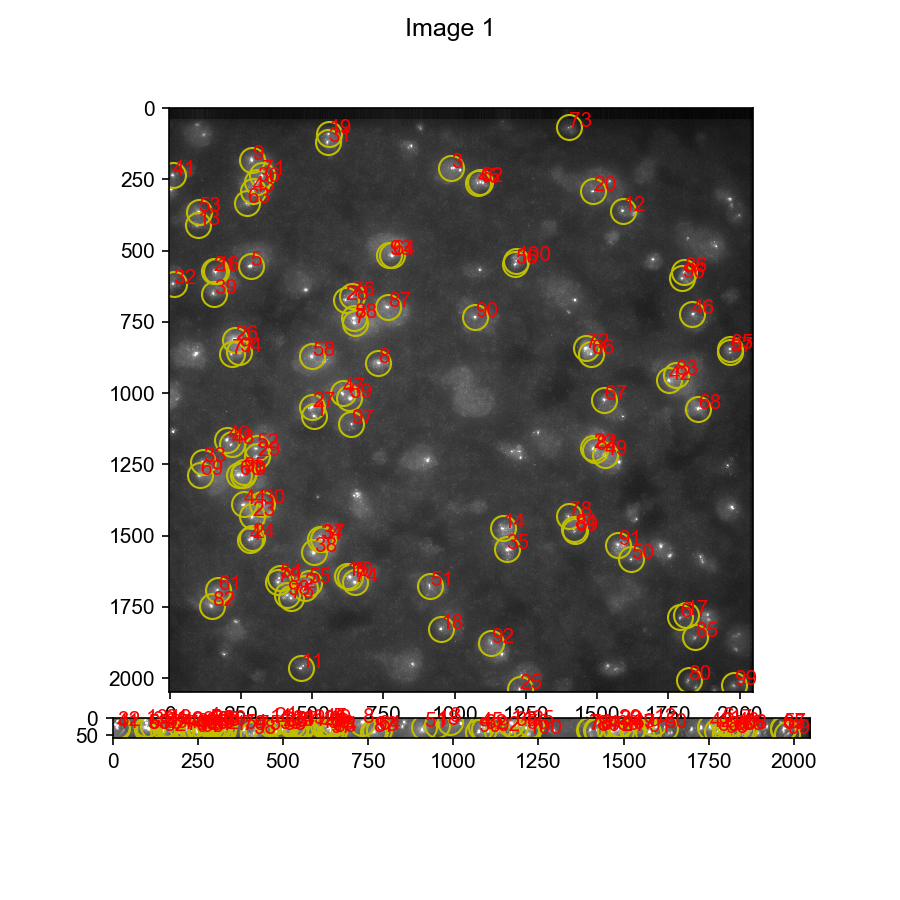

In [11]:
# visualize_selected_chromosomes for gene specified
%matplotlib notebook
%matplotlib notebook


gene_id =5

# further remove small chr if necessary
_chr_size_filter = 50

# extract all chr coords for gene specified
_cand_chrom_coords = _chrom_coords [str(gene_id)]
_removed_chr = np.sum(_cand_chrom_coords[:,-1]<= _chr_size_filter)
_cand_chrom_coords = _cand_chrom_coords[_cand_chrom_coords[:,-1]> _chr_size_filter ]
_cand_chrom_coords = _cand_chrom_coords[:,:3]

print (f'there are {_removed_chr} removed after post-size filtering.')

## visualize
coord_dict = {'coords':[],
              'class_ids':[],
             }

coord_dict['coords'] += list(np.flipud(_chrom_coord) for _chrom_coord in _cand_chrom_coords)
coord_dict['class_ids'] += list(np.zeros(len(_cand_chrom_coords),dtype=int))

fig=plt.figure(figsize=(6,6), dpi=150)    
    
visual_tools.imshow_mark_3d_v2([gene_ims[gene_id-1]],
                               fig=fig,
                               given_dic=coord_dict,
                               save_file=None,min_max_default =[4000,10000]
                               )

there are 21 removed after post-size filtering.


<IPython.core.display.Javascript object>


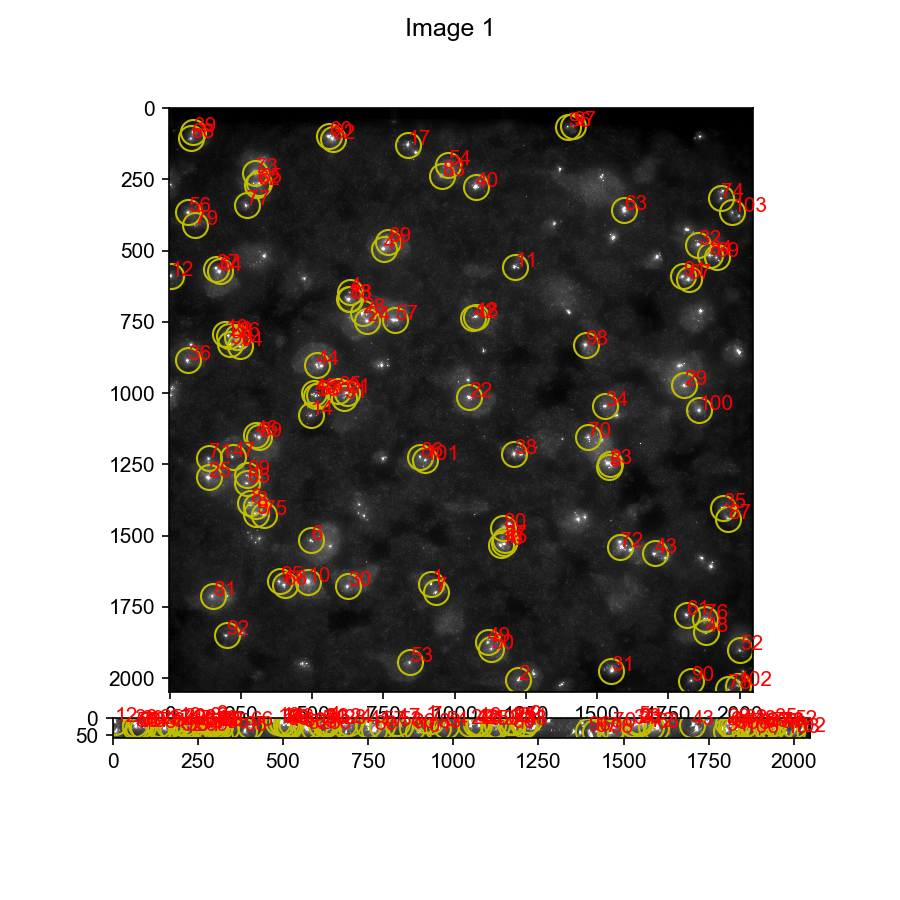

In [14]:
# visualize_selected_chromosomes for gene specified
%matplotlib notebook
%matplotlib notebook


gene_id =4

# further remove small chr if necessary
_chr_size_filter = 50

# extract all chr coords for gene specified
_cand_chrom_coords = _chrom_coords [str(gene_id)]
_removed_chr = np.sum(_cand_chrom_coords[:,-1]<= _chr_size_filter)
_cand_chrom_coords = _cand_chrom_coords[_cand_chrom_coords[:,-1]> _chr_size_filter ]
_cand_chrom_coords = _cand_chrom_coords[:,:3]

print (f'there are {_removed_chr} removed after post-size filtering.')

## visualize
coord_dict = {'coords':[],
              'class_ids':[],
             }

coord_dict['coords'] += list(np.flipud(_chrom_coord) for _chrom_coord in _cand_chrom_coords)
coord_dict['class_ids'] += list(np.zeros(len(_cand_chrom_coords),dtype=int))

fig=plt.figure(figsize=(6,6), dpi=150)    
    
visual_tools.imshow_mark_3d_v2([gene_ims[gene_id-1]],
                               fig=fig,
                               given_dic=coord_dict,
                               save_file=None,min_max_default =[4000,15000]
                               )

there are 4 removed after post-size filtering.


<IPython.core.display.Javascript object>


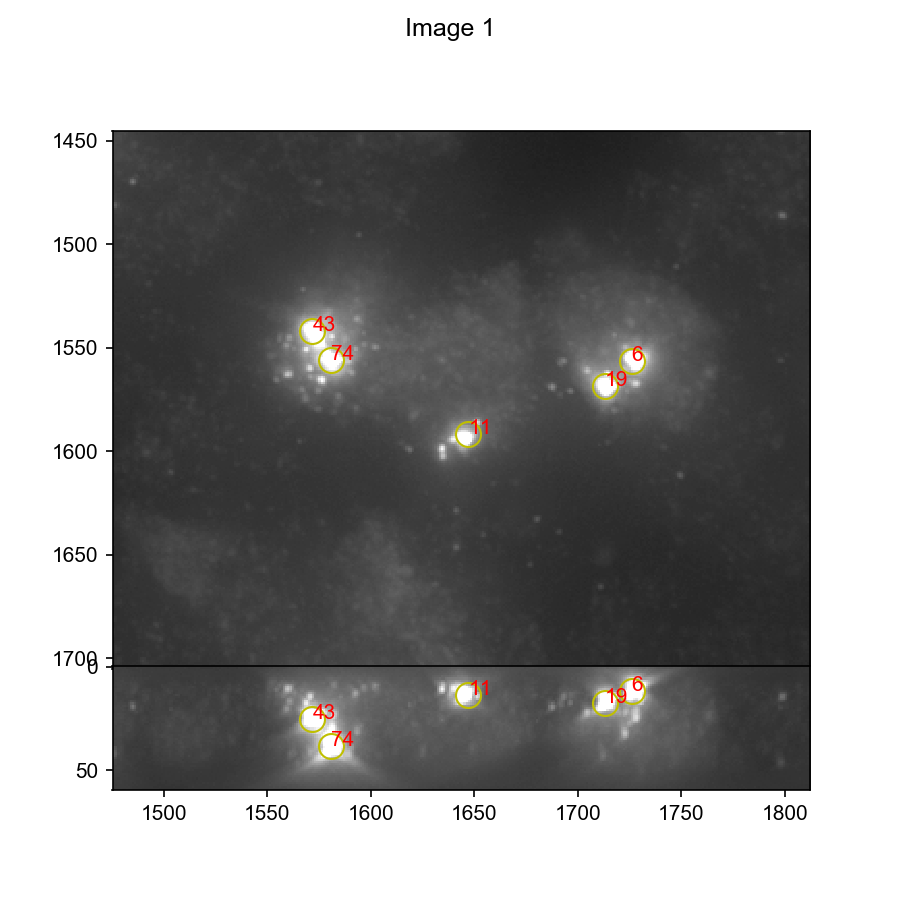

In [15]:
# visualize_selected_chromosomes for gene specified
%matplotlib notebook
%matplotlib notebook


gene_id =1

# further remove small chr if necessary
_chr_size_filter = 50

# extract all chr coords for gene specified
_cand_chrom_coords = _chrom_coords [str(gene_id)]
_removed_chr = np.sum(_cand_chrom_coords[:,-1]<= _chr_size_filter)
_cand_chrom_coords = _cand_chrom_coords[_cand_chrom_coords[:,-1]> _chr_size_filter ]
_cand_chrom_coords = _cand_chrom_coords[:,:3]

print (f'there are {_removed_chr} removed after post-size filtering.')

## visualize
coord_dict = {'coords':[],
              'class_ids':[],
             }

coord_dict['coords'] += list(np.flipud(_chrom_coord) for _chrom_coord in _cand_chrom_coords)
coord_dict['class_ids'] += list(np.zeros(len(_cand_chrom_coords),dtype=int))

fig=plt.figure(figsize=(6,6), dpi=150)    
    
visual_tools.imshow_mark_3d_v2([gene_ims[gene_id-1]],
                               fig=fig,
                               given_dic=coord_dict,
                               save_file=None,min_max_default =[4000,25000]
                               )

## Generate spot intensity threshold for spot picking

### 2. If load from file

In [7]:
# load saved spot intensity for each region image

fov._load_from_file('signal', _load_attr_list=['spot_intensity_th'], _overwrite=True)

+ loading signal from file: \\10.245.74.40\Turing3\Pu\Analyzed_Data\20210624-P_Forebrain_smFISH_CTP09\Conv_zscan_02.hdf5
++ base attributes loaded:['spot_intensity_th'] in 0.046s.


['spot_intensity_th']

In [8]:
fov.spot_intensity_th

{'1': 670.0074462890625,
 '10': 3138.568115234375,
 '11': 1251.958984375,
 '12': 2917.249755859375,
 '13': 960.0530395507812,
 '14': 2441.36669921875,
 '15': 907.1475219726562,
 '16': 2117.69873046875,
 '17': 1220.8114013671875,
 '18': 2155.83984375,
 '19': 872.2504272460938,
 '2': 3368.773681640625,
 '20': 2825.83251953125,
 '21': 926.24951171875,
 '22': 1279.4588623046875,
 '23': 805.1640625,
 '24': 1600.0399169921875,
 '25': 829.1142578125,
 '26': 1432.955322265625,
 '27': 989.8816528320312,
 '28': 1184.632568359375,
 '29': 805.701904296875,
 '3': 1990.6112060546875,
 '30': 1014.1683349609375,
 '31': 540.7426147460938,
 '32': 2334.279296875,
 '33': 1062.478271484375,
 '34': 2453.572509765625,
 '35': 1361.916015625,
 '36': 3032.76708984375,
 '37': 1126.15771484375,
 '38': 2864.072509765625,
 '39': 899.3671875,
 '4': 8582.5458984375,
 '40': 2519.6982421875,
 '41': 939.0310668945312,
 '42': 2043.10498046875,
 '43': 1045.6925048828125,
 '44': 1988.2218017578125,
 '45': 1035.397583007812

### 2. If generate using function

In [11]:
# find spot intensity for each region image

spot_th_dict = fov._find_itensity_th_for_selected_spots_in_nucleus(_overwrite=False)

-- choose dapi images from folder: \\10.245.74.158\Chromatin_NAS_5\20210624-P_Forebrain_smFISH_CTP09\H1R1.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210624-P_Forebrain_smFISH_CTP09\H1R1\Conv_zscan_02.dax
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210624-P_Forebrain_smFISH_CTP09\H1R1\Conv_zscan_02.dax  in 5.177s
-- removing hot pixels for channels:['405'] in 10.450s
-- illumination correction for channels: 405, in 3.344s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 20.120s
-- saving fov_info to file: \\10.245.74.40\Turing3\Pu\Analyzed_Data\20210624-P_Forebrain_smFISH_CTP09\Conv_zscan_02.hdf5
++ base attributes saved:['dapi_im'] in 18.065s.
+ loading combo from file: \\10.245.74.40\Turing3\Pu\Analyzed_Data\20210624-P_Forebrain_smFISH_CTP09\Conv_zscan_02.hdf5
+ estimate intensity threshold for region 1.
-- find spot pea

 ### Visualiz combo images

In [13]:
# Load combo image

with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_ims = _grp['ims'][:5]
    combo_ids = _grp['ids'][:5]

        #gene_raw_spot_list.append(_grp['raw_spots'][_ind])

In [15]:
fov.combo_spots_list

array([array([[ 7.63755225e+03,  1.32184067e+01,  4.07602478e+02, ...,
         5.19445777e-01, -2.21391916e-01,  3.64633606e+02],
       [ 7.97297021e+03,  5.71878433e+00,  1.43615442e+03, ...,
        -2.27161646e-01,  7.79735483e-03,  2.62657349e+02],
       [ 5.56835205e+03,  7.91159248e+00,  1.50495654e+03, ...,
        -1.20838061e-01,  1.02549426e-01,  2.32486526e+02],
       ...,
       [ 4.08321991e+02,  7.66333103e+00,  8.01406067e+02, ...,
        -1.00000000e+00, -8.22779715e-01,  1.02990952e+02],
       [ 3.97852264e+02,  1.02033701e+01,  1.67309229e+03, ...,
        -1.00000000e+00,  1.00000000e+00,  9.86101990e+01],
       [ 3.48677032e+02,  1.36609097e+01,  1.50552148e+03, ...,
        -9.99006867e-01,  1.00000000e+00,  1.10863785e+02]], dtype=float32),
       array([[ 3.8383043e+04,  1.1805985e+01,  1.5262628e+03, ...,
         2.7786596e-02,  5.1054552e-02,  1.3958354e+03],
       [ 2.8006199e+04,  7.9486179e+00,  6.4812500e+02, ...,
        -7.5351685e-02,  5.3579383

In [16]:
fov.combo_drifts

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.33333334e-02,  1.33900003e+01, -6.75333357e+00],
       [-2.33333334e-02,  1.33900003e+01, -6.75333357e+00],
       [-1.13333337e-01,  3.01266670e+01, -1.11633329e+01],
       [-1.13333337e-01,  3.01266670e+01, -1.11633329e+01],
       [-1.09999999e-01,  3.06366673e+01, -1.02266665e+01],
       [-1.09999999e-01,  3.06366673e+01, -1.02266665e+01],
       [-8.66666660e-02,  3.10166664e+01, -1.04600000e+01],
       [-8.66666660e-02,  3.10166664e+01, -1.04600000e+01],
       [-1.16666667e-01,  3.22599983e+01, -9.64999962e+00],
       [-1.16666667e-01,  3.22599983e+01, -9.64999962e+00],
       [-1.03333332e-01,  3.78199997e+01, -9.62666702e+00],
       [-1.03333332e-01,  3.78199997e+01, -9.62666702e+00],
       [-9.66666639e-02,  3.85266685e+01, -9.34000015e+00],
       [-9.66666639e-02,  3.85266685e+01, -9.34000015e+00],
       [-7.66666681e-02,  3.45099983e+01

In [17]:
_spots_test = fov.combo_spots_list[0]

_spots_test[:,0]

array([7637.5522 , 7972.97   , 5568.352  , ...,  408.322  ,  397.85226,
        348.67703], dtype=float32)

In [7]:
vis_combo_inds = [0,1]
vis_combo_ims, vis_combo_ids, vis_combo_spot_list, vis_combo_raw_spot_list = [], [], [], []

with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    
    for _ind in vis_combo_inds:
        vis_combo_ims.append(_grp['ims'][_ind])
        vis_combo_ids.append(_grp['ids'][_ind])
        #_picked_inds = picked_spot_inds_list[_ind]
        #_picked_inds = np.array(_picked_inds[np.isnan(_picked_inds)==False], dtype=np.int)
        #vis_spot_list.append(raw_spots_list[_ind][_picked_inds])
        vis_combo_raw_spot_list.append( _grp['raw_spots'][_ind][_grp['raw_spots'][_ind][:,0] > spot_th_dict[str(_ind+1)]])

<IPython.core.display.Javascript object>


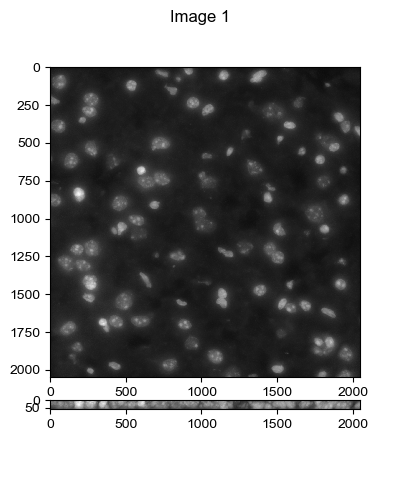

In [20]:
visual_tools.imshow_mark_3d_v2([fov.dapi_im])

<IPython.core.display.Javascript object>


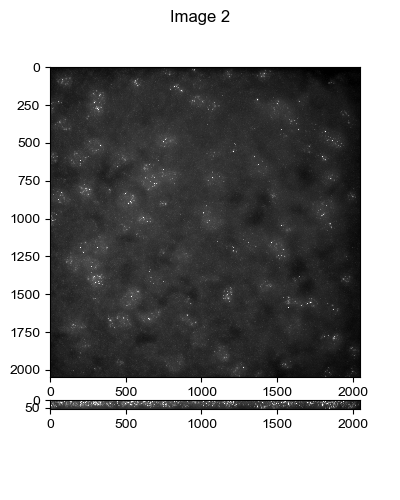

In [18]:
visual_tools.imshow_mark_3d_v2(vis_combo_ims)

<IPython.core.display.Javascript object>


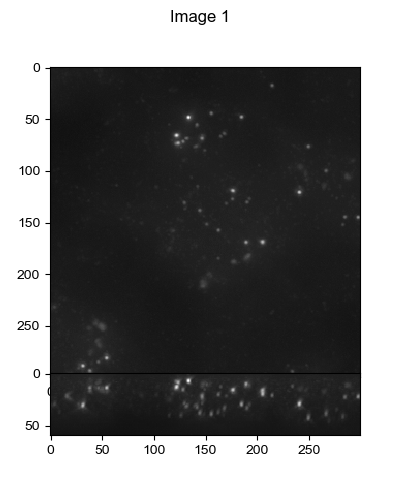

In [19]:
visual_tools.imshow_mark_3d_v2([vis_combo_ims[1][:,600:900,500:800]])

<IPython.core.display.Javascript object>


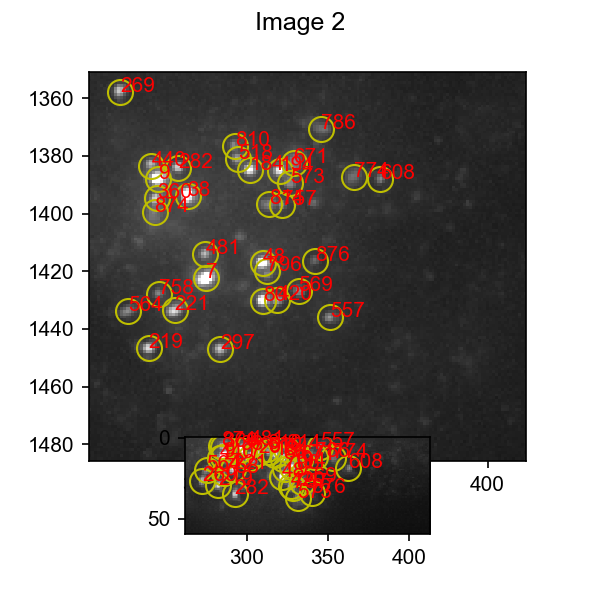

In [9]:
# visualize_all_chromosomes
%matplotlib notebook
%matplotlib notebook

## visualize
coord_dict = {'coords':[],
              'class_ids':[],
             }
for _i, _spots in enumerate(vis_combo_raw_spot_list):
    _sel_spots = _spots
    coord_dict['coords'] += list(np.flipud(_spot[1:4]) for _spot in _sel_spots)
    coord_dict['class_ids'] += list(_i * np.ones(len(_sel_spots),dtype=np.int))

fig=plt.figure(figsize=(4,4), dpi=150)    
    
visual_tools.imshow_mark_3d_v2(list(vis_combo_ims), 
                               fig=fig,
                               given_dic=coord_dict,
                               save_file=None,
                               )

In [6]:
spot_th_dict

{'1': 670.0074327556522, '2': 3368.7735856193576}

there are 709 spots kept after post-size filtering; on average, 141.8 spots kepts for each gene.


<IPython.core.display.Javascript object>


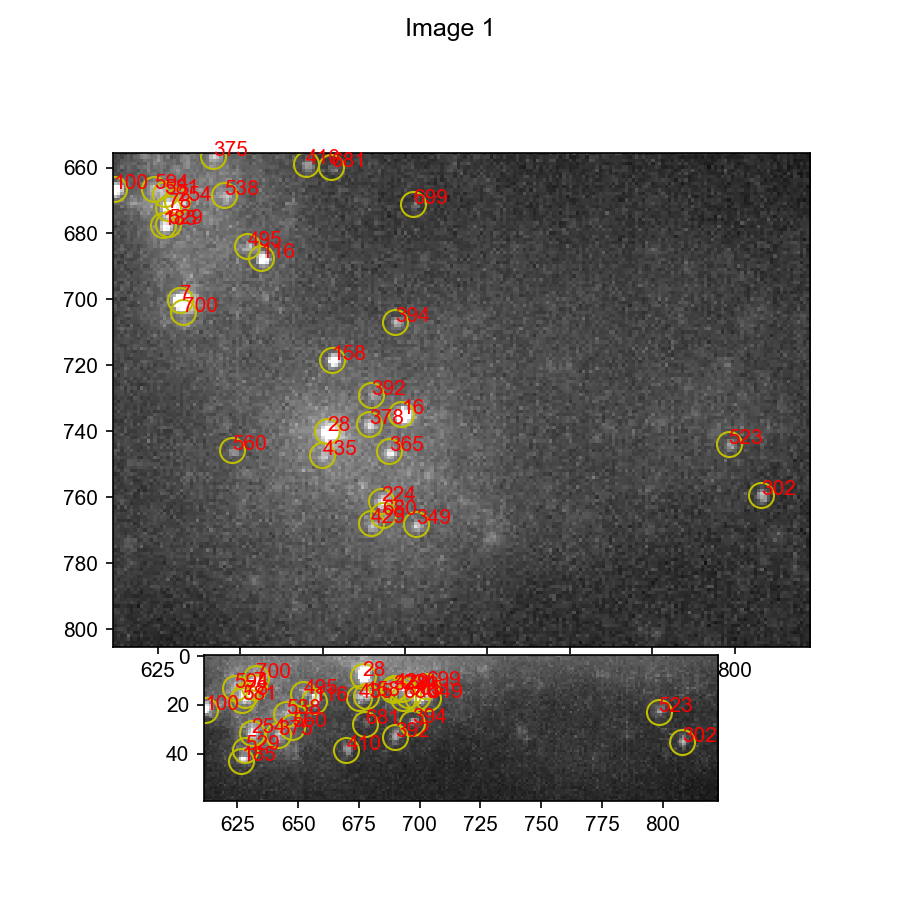

In [42]:
# visualize_selected_chromosomes for gene specified
%matplotlib notebook
%matplotlib notebook


_rel_combo_id =0   

# test region as specified
_spots_test =fov.combo_spots_list[0]
# spot intensity larger than the intensity th found
_spots_test = _spots_test [_spots_test [:,0] >spot_th_dict[str(_rel_combo_id+1)]]

# apply drift for unwarpped image
_spots_test = _spots_test[:,1:4] + fov.combo_drifts[_rel_combo_id]

print (f'there are {len(_spots_test)} spots kept after post-size filtering; on average, {len(_spots_test)/5} spots kepts for each gene.')

## visualize
coord_dict = {'coords':[],
              'class_ids':[],
             }

coord_dict['coords'] += list(np.flipud(_spot_coord) for _spot_coord in _spots_test)
coord_dict['class_ids'] += list(np.zeros(len(_spots_test),dtype=int))

fig=plt.figure(figsize=(6,6), dpi=150)    
    
visual_tools.imshow_mark_3d_v2([combo_ims[_rel_combo_id]],
                               fig=fig,
                               given_dic=coord_dict,
                               save_file=None,min_max_default =[6000,8000]
                               )